# Forest carbon accounting
This notebook reads, transforms, and plots selected elements of the look-up tables from [Schedule 6 of the Climate Change (Forestry Sector) Regulations 2008](https://www.legislation.govt.nz/regulation/public/2008/0355/latest/DLM1633733.html).

## Look-up tables
The look-up tables are stored as four separate files in CSV format, e.g. ``table1.csv``. They contain pre-calculated values for the *cumulative* carbon stock $S_a^T$ measured in tonnes per hectare of a given forest type $T$ and age $a=0,1,\dots,a^{\rm max}_{T}$ (in years), where $a^{\rm max}_{T} = 50$ for all $T$ except for $T =$ "Exotic hardwood" (which extends only up to 35 years). 

We can calculate the annual carbon stock *change* $s_a^T$ using the following formula:

$$
s_a^T = \left\{
\begin{array}{lcl}
0 & \mathrm{for} & a = 0, \\
S_a^T - S_{a-1}^T & \mathrm{for} & a = 1,\dots, a^{\rm max}_{T}.
\end{array} \right.
$$

The graphs below plot $S_{a}^{T}$ and $s_{a}^{T}$ vs $a$ for a given $T$, which the user can select using a drop-down menu.

In [1]:
import pandas as pd             # for handling dataframes
import matplotlib.pyplot as plt # for plotting data
import ipywidgets as widgets    # for interactivity

In [21]:
# Function for calculating annual carbon stock change per hectare
def stock_change(y, T, table):
    return round(table[T][y] - table[T][y-1], 1)

# Function for calling stock_change over the entire time span 
def stock_changes(T, table):
    values=[0]
    for y in range(1, len(table)):
        values.append(stock_change(y,T,table))
    return values

# load first two tables as dataframes and merge into one
table = pd.concat([pd.read_csv('table1.csv'),
                   pd.read_csv('table2.csv')], axis = 1)

# drop both 'Age' columns, since age matches row index
table.drop('Age (yrs)', inplace = True, axis = 1)

# prepend "P.Radiata" to regionalised Pinus Radiata.
subs = {}
for label in table.columns:
    if(len(label.split()) == 1): 
        subs[label]="P.Radiata in "+label
table = table.rename(columns = subs)

# show first few rows of the final table
table.head(10)

,P.Radiata in Ak,P.Radiata in W/T,P.Radiata in BOP,P.Radiata in Gis,P.Radiata in H/SNI,P.Radiata in N/M,P.Radiata in C/W,P.Radiata in O,P.Radiata in S,Douglas fir,Exotic softwoods,Exotic hardwoods,Indigenous forest
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,0.4,0.4,0.6,0.5,0.2,0.2,0.3,0.2,0.1,0.2,0.1,0.6
2,3.0,3.0,2.0,4.0,3.0,1.0,1.0,2.0,1.0,0.1,1.0,3.0,1.2
3,8.0,7.0,6.0,10.0,9.0,3.0,2.0,5.0,3.0,0.4,3.0,13.0,2.5
4,29.0,25.0,24.0,37.0,34.0,12.0,5.0,9.0,14.0,1.0,12.0,34.0,4.6
5,59.0,50.0,51.0,77.0,71.0,28.0,15.0,26.0,35.0,2.0,26.0,63.0,7.8
6,98.0,84.0,84.0,121.0,113.0,48.0,31.0,49.0,65.0,4.0,45.0,98.0,12.1
7,131.0,111.0,118.0,162.0,155.0,73.0,53.0,72.0,99.0,7.0,63.0,137.0,17.5
8,153.0,130.0,143.0,190.0,185.0,100.0,76.0,94.0,134.0,20.0,77.0,176.0,24.0
9,166.0,142.0,155.0,201.0,197.0,117.0,101.0,124.0,160.0,33.0,87.0,214.0,31.6


In [22]:
# Wrap the plotting in a callable function
def plot_table(T, table):
    
    years = list(range(len(table)))
    stock = list(table[T].values)
    change = stock_changes(T=T,table=table);

    # Instantiate figure for plotting
    fig, axs = plt.subplots(2, figsize=[8.0,6.0], sharex = True)
    
    axs[0].plot(stock)
    axs[0].set_ylim(0)
    axs[0].set_ylabel("carbon stock \n (tons/ha)")
    
    axs[1].bar(x = years, 
               height = change, 
               width = -1.0, # -ve to align with right edge
               align = 'edge')
    axs[1].set_xlim(years[0],years[-1])
    axs[1].set_xlabel("age (years)")
    axs[1].set_ylabel("annual change \n(tons/ha)")

    return fig

# Define widgets for the forest type
T_widget = widgets.Dropdown(options = list(table.columns), 
                            value = 'Indigenous forest', 
                            description = 'forest type')

# Instantiate an interactive plot
ifig = widgets.interactive(plot_table, 
                           T = T_widget, 
                           table = widgets.fixed(table))

# Show the plot
ifig

interactive(children=(Dropdown(description='forest type', index=12, options=('P.Radiata in Ak', 'P.Radiata in …

## Claim template

Here we consider the annual carbon stock change in a forest claimed over a number of consecutive reporting years. The calculation requires two additional parameters: $a_{0}$ - the forest age at the start of the first reporting year; and $N$ - the total number of reporting years. 

Since the underlying look-up tables do not extend beyond 50 years, $a_{0}$ must satisfy $a_{0} < 50$ and $N$ must satisfy $N \leq 50 - a_{0}$. Note that the range of validity for $N$ depends on the value of $a_{0}$.

In [42]:
# Function for calling stock_change over a time window 
def claim_years(N, a0, T, table):
    
    if(N + a0 <= 50):
        values=[]
        for y in range(a0+1, a0+N+1):
            values.append(stock_change(y,T,table))
        return values
    else:
        return None

In [50]:
claim_years(N = 5, 
            a0 = 5, 
            T = 'Indigenous forest', 
            table = table)

[4.3, 5.4, 6.5, 7.6, 8.6]

In [69]:
def plot_claim(N, a0, T, table):
    
    domain = list(range(1,N+1))
    values = claim_years(N = N, a0 = a0, T = T, table = table)
    
    # Instantiate figure for plotting
    fig = plt.figure()
    plt.bar(x = domain, 
            height = values, 
            width = 0.75, # -ve to align with right edge
            align = 'center')
    plt.xlim(domain[0]-0.5,domain[-1]+0.5)
    plt.xlabel("reporting year")
    plt.ylabel("annual claim (tons/ha)")
    plt.title('Total carbon claimed: '
              +str(sum(values))+
              ' tons / ha', fontsize=15)
    plt.show()
    

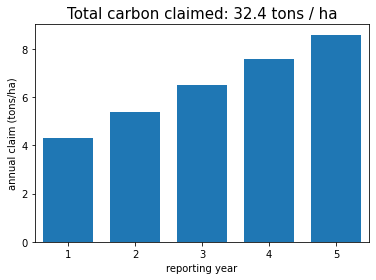

In [70]:
plot_claim(N = 5, 
           a0 = 5, 
           T = 'Indigenous forest', 
           table = table)

In [82]:
# Define widgets for the three parameters
T_widget = widgets.Dropdown(options = list(table.columns[1:]), 
                            value = 'Indigenous forest', 
                            description='$T$')

a0_widget = widgets.IntSlider(value = 0,
                              min = 0,
                              max = 49,
                              description = '$a_{0}$')

N_widget = widgets.IntSlider(value=10, 
                               min=1, 
                               max=50, 
                               description='$N$')

# Make special case for Exotic hardwood
def update_a0_range(*args):
    if(T_widget.value == 'Exotic hardwoods'):
        a0_widget.max = 35
    else:
        a0_widget.max = 50

T_widget.observe(update_a0_range, 'value')

# Need to dynamically update the range of validity of N_widget
def update_N_range(*args):
    N_widget.max = a0_widget.max - a0_widget.value

a0_widget.observe(update_N_range, 'value')


# Instantiate an interactive plot
ifig = widgets.interactive(plot_claim, 
                           T = T_widget, 
                           a0 = a0_widget, 
                           N = N_widget, 
                           table = widgets.fixed(table))

# Show the plot
ifig

interactive(children=(IntSlider(value=10, description='$N$', max=50, min=1), IntSlider(value=0, description='$…